Importando bibliotecas necessárias para o desenvolvimento

In [175]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from openai import OpenAI
import openai
from keys import openai_key, nasa_key

Criando variáveis e consumindo a API da Nasa

In [176]:
nasa_key = nasa_key


base_url = 'https://api.nasa.gov/neo/rest/v1/feed'


start_date = (datetime.now() - timedelta(days=7)).strftime('%Y-%m-%d')
end_date = datetime.now().strftime('%Y-%m-%d')

params = {
    'start_date': start_date,
    'end_date': end_date,
    'api_key': nasa_key
}

response = requests.get(base_url, params=params)
data = response.json()

In [177]:
openai.api_key = openai_key
headers = {'Authorization': f'Bearer {openai_key}', 'Content-Type': 'application/json'}
link = 'https://api.openai.com/v1/chat/completions'
id_model = 'gpt-4o'

def get_ai_response(prompt):
    body_message = {
        'model': id_model,
        'messages': [{'role': 'user', 'content': prompt}]
    }

    response_ai = requests.post(link, headers=headers, json=body_message)  # Use json= para enviar o corpo como JSON
    return response_ai.json()

Visualizando como a API está distribuída


Tratando a api e gerando uma lista com os dados que foram selecionados

In [178]:
asteroids = []
for date, asteroids_list in data['near_earth_objects'].items():
    for asteroid in asteroids_list:
        asteroids.append({
            'name': asteroid['name'],
            'close_approach_date': date,
            'velocity_kmh': asteroid['close_approach_data'][0]['relative_velocity']['kilometers_per_hour'],
            'estimated_diameter_min': asteroid['estimated_diameter']['meters']['estimated_diameter_min'],
            'estimated_diameter_max': asteroid['estimated_diameter']['meters']['estimated_diameter_max'],
            "miss_distance_km": asteroid['close_approach_data'][0]['miss_distance']['kilometers'],
            'is_potentially_hazardous': asteroid['is_potentially_hazardous_asteroid']
        })

Criando o DataFrame a partir da lista 'asteroids'

In [179]:
df_asteroids = pd.DataFrame(asteroids)

Visualizando as primeiras linhas

In [180]:
df_asteroids.head()

,name,close_approach_date,velocity_kmh,estimated_diameter_min,estimated_diameter_max,miss_distance_km,is_potentially_hazardous
0,412977 (1990 UO),2024-10-20,148185.7480262956,324.007435,724.502651,69887104.254764291,False
1,495615 (2015 PQ291),2024-10-20,82317.0440716297,766.575574,1714.115092,52394019.758446318,False
2,526742 (2006 WR127),2024-10-20,53453.4606550249,212.106988,474.285643,41208195.072126918,False
3,(2014 US115),2024-10-20,68985.4822516714,31.956189,71.456210,57336403.669540838,False
4,(2015 KG19),2024-10-20,27404.305513672,55.789822,124.749835,33890943.164648171,False


Criando o diametro estimado médio para cada asteroide

In [181]:
df_asteroids['estimated_diameter_mean'] = (df_asteroids['estimated_diameter_max'] + df_asteroids['estimated_diameter_min']) / 2

In [182]:
df_asteroids

,name,close_approach_date,velocity_kmh,estimated_diameter_min,estimated_diameter_max,miss_distance_km,is_potentially_hazardous,estimated_diameter_mean
0,412977 (1990 UO),2024-10-20,148185.7480262956,324.007435,724.502651,69887104.254764291,False,524.255043
1,495615 (2015 PQ291),2024-10-20,82317.0440716297,766.575574,1714.115092,52394019.758446318,False,1240.345333
2,526742 (2006 WR127),2024-10-20,53453.4606550249,212.106988,474.285643,41208195.072126918,False,343.196316
3,(2014 US115),2024-10-20,68985.4822516714,31.956189,71.456210,57336403.669540838,False,51.706199
4,(2015 KG19),2024-10-20,27404.305513672,55.789822,124.749835,33890943.164648171,False,90.269828
...,...,...,...,...,...,...,...,...
149,(2024 TQ3),2024-10-22,30556.439124071,56.306039,125.904131,24102959.659147515,False,91.105085
150,(2024 UL),2024-10-22,45176.9657045404,58.499880,130.809709,12790801.456546277,False,94.654794
151,(2024 UR),2024-10-22,58739.0993249447,36.354232,81.290534,2109018.399516151,False,58.822383
152,(2024 US),2024-10-22,28169.6271792723,6.744581,15.081342,362447.96340405,False,10.912961


Visualizando informações sobre o DataFrame, como o tipo de dado de cada coluna

In [183]:
df_asteroids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   name                      154 non-null    object 
 1   close_approach_date       154 non-null    object 
 2   velocity_kmh              154 non-null    object 
 3   estimated_diameter_min    154 non-null    float64
 4   estimated_diameter_max    154 non-null    float64
 5   miss_distance_km          154 non-null    object 
 6   is_potentially_hazardous  154 non-null    bool   
 7   estimated_diameter_mean   154 non-null    float64
dtypes: bool(1), float64(3), object(4)
memory usage: 8.7+ KB


Ajustando o tipo de dados para as colunas necessárias

In [184]:
df_asteroids['close_approach_date'] = pd.to_datetime(df_asteroids['close_approach_date'])

df_asteroids['miss_distance_km'] = df_asteroids['miss_distance_km'].astype('float64')

df_asteroids['velocity_kmh'] = df_asteroids['velocity_kmh'].astype('float64')

Descrição estatítisca dos dados das colunas de data e numéricas

In [185]:
df_asteroids.describe()

,close_approach_date,velocity_kmh,estimated_diameter_min,estimated_diameter_max,miss_distance_km,estimated_diameter_mean
count,154,154.000000,154.000000,154.000000,1.540000e+02,154.000000
mean,2024-10-22 03:44:24.935064832,44937.962640,93.953946,210.087411,3.245644e+07,152.020679
min,2024-10-19 00:00:00,4966.978391,2.731209,6.107170,4.636481e+04,4.419189
25%,2024-10-20 00:00:00,28716.141426,18.434951,41.221803,1.289759e+07,29.828377
50%,2024-10-22 00:00:00,42411.983556,39.680158,88.727532,3.061123e+07,64.203845
75%,2024-10-24 00:00:00,55778.474189,94.635883,211.612268,5.273305e+07,153.124076
max,2024-10-26 00:00:00,148185.748026,996.678240,2228.640296,7.363303e+07,1612.659268
std,NaN,22935.845485,154.941919,346.460665,2.303389e+07,250.701292


### Primeira Análise - Número de Asteróides que passaram próximo da Terra

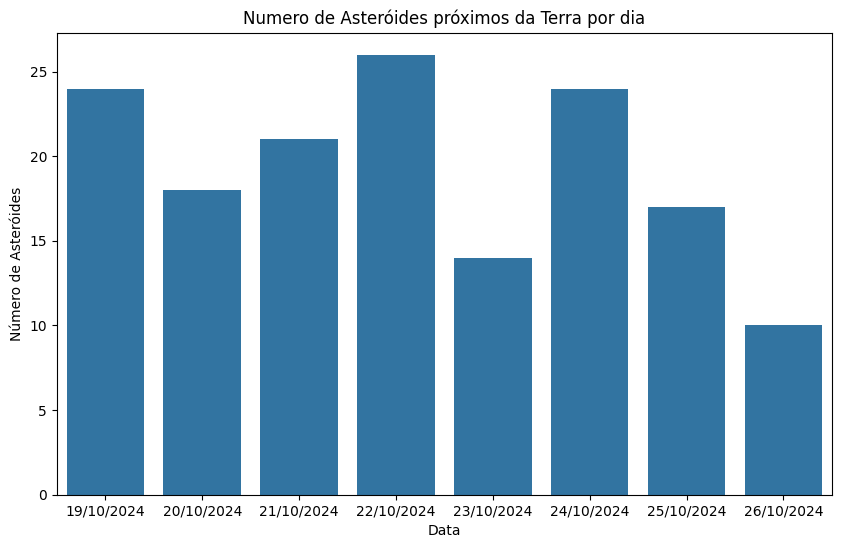

Os dados fornecidos mostram o número de asteroides próximos da Terra ao longo de um período de oito dias em outubro de 2024. Aqui estão algumas observações que podemos fazer com base nesses dados:

1. **Variabilidade Diária:** Há uma variação considerável no número de asteroides próximos da Terra de um dia para o outro. O número varia de um mínimo de 10 asteroides em 26/10/2024 a um máximo de 26 asteroides em 22/10/2024 e 24/10/2024. Essa variabilidade pode ser normal devido a diferentes trajetórias e velocidades dos asteroides.

2. **Tendência Geral:** Não há uma tendência clara de aumento ou diminuição do número de asteroides ao longo deste curto período. O número varia sem um padrão discernível, o que pode sugerir que a presença de asteroides próximos da Terra é bastante aleatória.

3. **Condições Astronômicas:** A distribuição aleatória observada nesses dias pode ser influenciada por fatores astronômicos, como a posição da Terra em relação a cinturões de asteroides ou outros corpos

In [186]:
asteroids_per_day = df_asteroids['close_approach_date'].value_counts().sort_index()
asteroids_per_day.index = asteroids_per_day.index.strftime('%d/%m/%Y')
plt.figure(figsize=(10,6))
sns.barplot(x=asteroids_per_day.index, y=asteroids_per_day.values)
plt.title('Numero de Asteróides próximos da Terra por dia')
plt.xlabel('Data')
plt.ylabel('Número de Asteróides')
plt.show()

prompt = f"Os dados a seguir mostram o número de asteroides próximos da Terra por dia: {asteroids_per_day.to_dict()}. Comente sobre o que esses dados podem indicar sobre a atividade de asteroides."

print(response_ai['choices'][0]['message']['content'])

### Segunda Análise - Proporção de ateroides perigosos/não perigosos á Terra

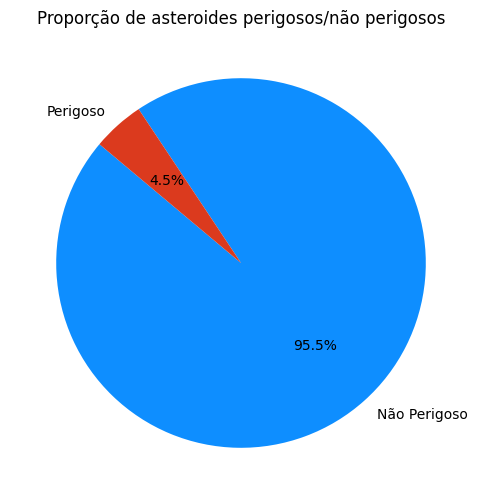

In [187]:
plt.figure(figsize=(12, 6))
hazardous_count = df_asteroids['is_potentially_hazardous'].value_counts()
plt.pie(hazardous_count, labels=['Não Perigoso', 'Perigoso'], autopct='%1.1f%%', startangle=140, colors=['#0E8EFF', '#DB3A1E'])
plt.title('Proporção de asteroides perigosos/não perigosos')
plt.show()

### Terceira Análise - Visualizando correlação entre Menor distância e diâmetro máximo estimado

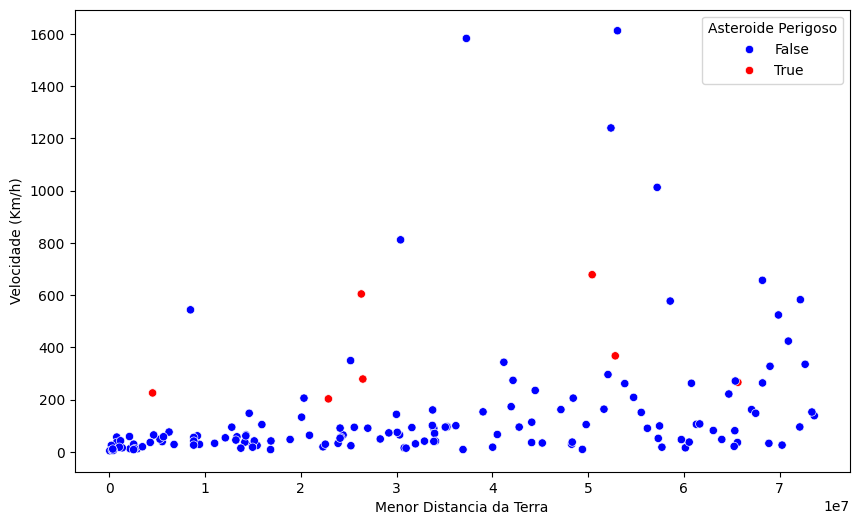

In [188]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='miss_distance_km', y='estimated_diameter_mean', hue='is_potentially_hazardous', 
                data=df_asteroids, palette={True: 'red', False: 'blue'})
plt.xlabel('Menor Distancia da Terra')
plt.ylabel('Velocidade (Km/h)')
plt.legend(title='Asteroide Perigoso')
plt.show()

### Quarta Análise - Visualizando a distribuição de diametro máximo dos asteroides

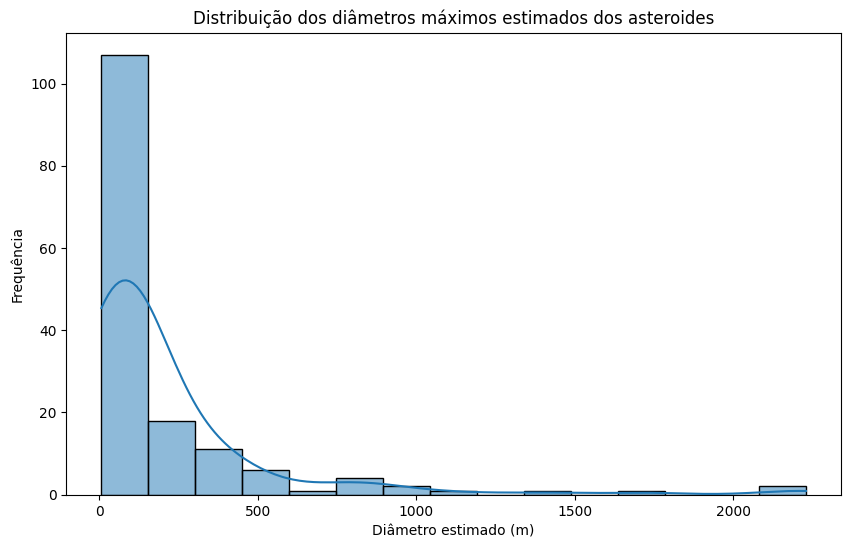

In [189]:
plt.figure(figsize=(10, 6))
sns.histplot(df_asteroids['estimated_diameter_max'], kde=True, bins=15)
plt.title('Distribuição dos diâmetros máximos estimados dos asteroides')
plt.xlabel('Diâmetro estimado (m)')
plt.ylabel('Frequência')
plt.show()

### Quinta Análise - Vendo a distribuição das velocidades

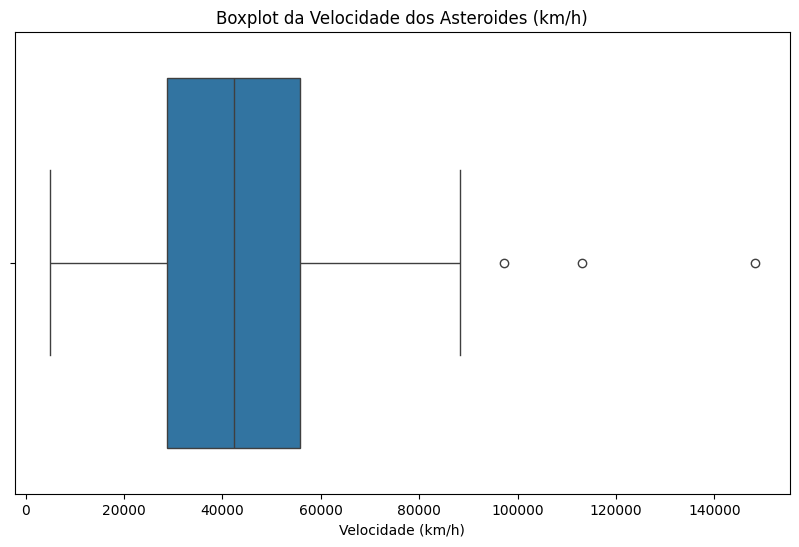

In [190]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='velocity_kmh', data=df_asteroids)
plt.title('Boxplot da Velocidade dos Asteroides (km/h)')
plt.xlabel('Velocidade (km/h)')
plt.show()

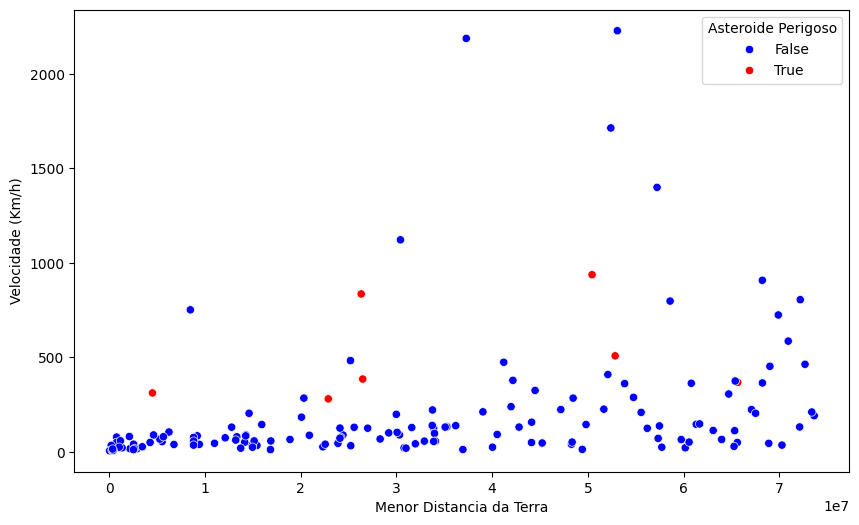

In [191]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='miss_distance_km', y='estimated_diameter_max', hue='is_potentially_hazardous', 
                data=df_asteroids, palette={True: 'red', False: 'blue'})
plt.xlabel('Menor Distancia da Terra')
plt.ylabel('Velocidade (Km/h)')
plt.legend(title='Asteroide Perigoso')
plt.show()